<a href="https://colab.research.google.com/github/shiva-lab/Walmart-M5_AccuracyPrediction/blob/master/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
pip install plotly==4.9.0

In [ ]:
import plotly.express as px

In [ ]:
sales = pd.read_csv('/content/gdrive/My Drive/Kaggle/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/content/gdrive/My Drive/Kaggle/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/content/gdrive/My Drive/Kaggle/sell_prices.csv')
prices.name = 'prices'

In [ ]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)  #add sales infoemation from d1942 to d1969 which set as 0

In [ ]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,4,0,0,0,0,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,2,0,0,0,2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,4,0,1,3,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,1,0,1,0,3,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,3,1,0,0,1,2,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,1,1,1,1,4,6,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [ ]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()


In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0


In [ ]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
#remove the information of 12-25 of each year since it's christmas
df=df[-(df['date']== "2011-12-25")&-(df['date']== "2012-12-25")&-(df['date']== "2013-12-25")&-(df['date']== "2014-12-25")&-(df['date']== "2015-12-25")]


In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273


In [ ]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)


In [ ]:
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()


In [ ]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()


In [ ]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()


In [ ]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,0.0
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,0.0
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469,0.0
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273,0.0


In [ ]:
def introduce_nulls(df):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_metric(df,state,store,metric):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<='2016-05-22')]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],
                           name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],
                           name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ))
    return fig

In [ ]:
cal_data = group.copy()
cal_data = cal_data[cal_data.date <= '22-05-2016']
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()

In [ ]:
def calmap(cal_data, state, store, scale):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=store)
    return fig

In [ ]:
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [ ]:
del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data
gc.collect();

#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
df.drop('date',axis=1,inplace=True)

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,14370,1437,3,1,0,0,1,0,11101,2,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,3,...,2016,16,3,2,0,0,0,0,2.980469,0.0
60034806,14339,1433,2,0,9,2,1969,0,11621,3,...,2016,16,3,2,0,0,0,0,2.480469,0.0
60034807,14349,1434,2,0,9,2,1969,0,11621,3,...,2016,16,3,2,0,0,0,0,3.980469,0.0
60034808,14359,1435,2,0,9,2,1969,0,11621,3,...,2016,16,3,2,0,0,0,0,1.280273,0.0


In [ ]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,snap_WI,sell_price,revenue,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_6,sold_lag_12,sold_lag_24,sold_lag_36
0,14370,1437,3,1,0,0,1,0,11101,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,3,...,0,2.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60034806,14339,1433,2,0,9,2,1969,0,11621,3,...,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60034807,14349,1434,2,0,9,2,1969,0,11621,3,...,0,3.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60034808,14359,1435,2,0,9,2,1969,0,11621,3,...,0,1.280273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [ ]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [ ]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [ ]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [ ]:
df = df[df['d']>=36]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58815210 entries, 1067150 to 60034809
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [ ]:
df  

In [ ]:
# split data as training and test dataset
data = df
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [ ]:
#Get the store ids

stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    

    
    
    
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.655395	training's l2: 0.429543	valid_1's rmse: 0.399456	valid_1's l2: 0.159565
[40]	training's rmse: 0.613602	training's l2: 0.376508	valid_1's rmse: 0.381093	valid_1's l2: 0.145232
[60]	training's rmse: 0.588276	training's l2: 0.346069	valid_1's rmse: 0.36713	valid_1's l2: 0.134784
[80]	training's rmse: 0.569262	training's l2: 0.324059	valid_1's rmse: 0.360459	valid_1's l2: 0.12993
[100]	training's rmse: 0.556408	training's l2: 0.30959	valid_1's rmse: 0.356837	valid_1's l2: 0.127332
[120]	training's rmse: 0.545086	training's l2: 0.297119	valid_1's rmse: 0.351696	valid_1's l2: 0.12369
[140]	training's rmse: 0.536556	training's l2: 0.287892	valid_1's rmse: 0.346915	valid_1's l2: 0.12035
[160]	training's rmse: 0.528977	training's l2: 0.279816	valid_1's rmse: 0.347031	valid_1's l2: 0.120431
[180]	training's rmse: 0.522946	training's l2: 0.273472	valid_1's rmse: 0.34234

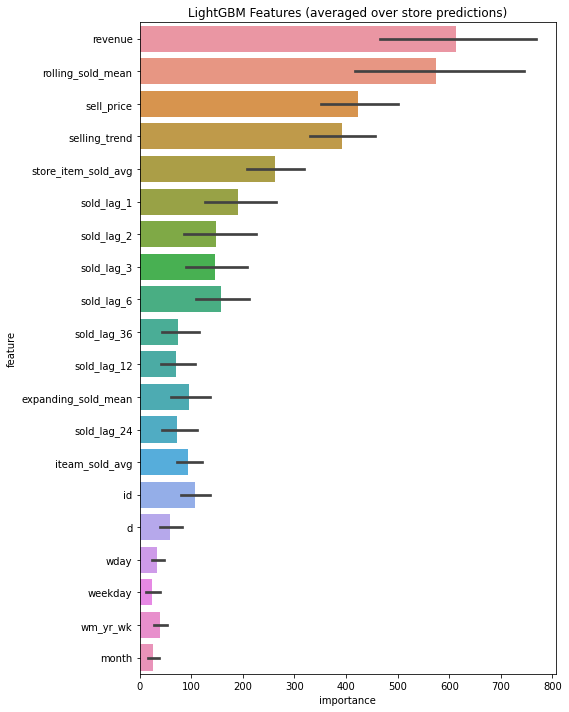

In [ ]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('/content/drive'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [ ]:
 #Get the validation results(We already have them as less than one month left for competition to end)
validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submissionfirstime.csv',index=False)